# Installations and Imports

In [1]:
%%capture
!pip install mujoco mujoco_mjx brax playground
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
!apt-get update
!apt-get install -y libosmesa6-dev libgl1-mesa-glx libglfw3 patchelf

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import mediapy
import mujoco
import os
from tqdm import tqdm

os.environ["MUJOCO_GL"] = "egl"

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Clone Repository

In [3]:
!git clone https://github.com/shaoanlu/control_system_project_template.git

Cloning into 'control_system_project_template'...
remote: Enumerating objects: 712, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 712 (delta 103), reused 198 (delta 59), pack-reused 453 (from 1)
Receiving objects: 100% (712/712), 7.78 MiB | 27.28 MiB/s, done.
Resolving deltas: 100% (323/323), done.


In [4]:
%cd control_system_project_template

/content/control_system_project_template


In [5]:
!pwd

/content/control_system_project_template


# Run simulation

In [6]:
from examples.mujoco_Go1.env_wrapper import Go1Env
from examples.mujoco_Go1.ppo import PPO, PPOParams, PPOParamsBuilder
from src.control.controller_factory import ControllerFactory

mujoco_menagerie not found. Downloading...


Cloning mujoco_menagerie: ██████████| 100/100 [00:29<00:00]


Checking out commit 5e6af47a49bf8ae27581615b54045107b20ce584
Successfully downloaded mujoco_menagerie


In [7]:
velocity_kick_range = [0.0, 0.0]  # Disable velocity kick.
kick_duration_range = [0.05, 0.2]


def sample_pert(rng, env, state):
    rng, key1, key2 = jax.random.split(rng, 3)
    pert_mag = jax.random.uniform(key1, minval=velocity_kick_range[0], maxval=velocity_kick_range[1])
    duration_seconds = jax.random.uniform(key2, minval=kick_duration_range[0], maxval=kick_duration_range[1])
    duration_steps = jax.numpy.round(duration_seconds / env.dt).astype(jax.numpy.int32)
    state.info["pert_mag"] = pert_mag
    state.info["pert_duration"] = duration_steps
    state.info["pert_duration_seconds"] = duration_seconds
    return rng

## Instantiate simulator and controller
### Choose `env_name` between `Go1Handstand` and `Go1JoystickFlatTerrain`

In [8]:
# instantiate mujoco Env
env_name = "Go1JoystickFlatTerrain"  # Choose between Go1Handstand and Go1JoystickFlatTerrain
rng = jax.random.PRNGKey(0)
env = Go1Env(env_name=env_name)

# Instantiate controller based on env_name
factory = ControllerFactory()
factory.register_controller(PPOParams, PPO)
controller_config = {"npy_path": f"examples/mujoco_Go1/nn_params/{env_name}"}
ppo_params = PPOParamsBuilder().build(config=controller_config)
controller = factory.build(params=ppo_params)

## Run closed loop simunation

In [9]:
rollout = []
modify_scene_fns = []
swing_peak = []
linvel = []
angvel = []
ref_commands = []

# Play around the controller by modifying command during runtime
cmd_yaw = np.pi
command = jax.numpy.array([0, 0, cmd_yaw])

# start closed-loop sim
state = env.reset(rng)
for i in tqdm(range(env.env_cfg.episode_length)):
    if (env_name == "Go1JoystickFlatTerrain") and (i % 250 == 0):
        cmd_yaw /= 2
        command = jax.numpy.array([0, 0, cmd_yaw])
        state.info["command"] = command
    try:
        if state.info["steps_since_last_pert"] < state.info["steps_until_next_pert"]:
            rng = sample_pert(rng, env, state)
    except:
        pass
    act_rng, rng = jax.random.split(rng)
    ctrl = controller.control(state.obs["state"])

    state = env.step(state, ctrl)
    rollout.append(state)
    ref_commands.append(command)
    linvel.append(env.get_global_linvel(state.data))
    angvel.append(env.get_gyro(state.data))
    if env_name == "Go1JoystickFlatTerrain":
        swing_peak.append(state.info["swing_peak"])

100%|██████████| 1000/1000 [00:57<00:00, 17.52it/s]


# Visualize Simulation Result

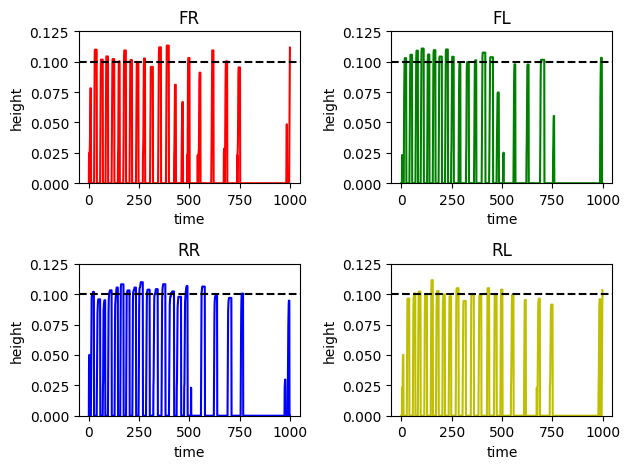

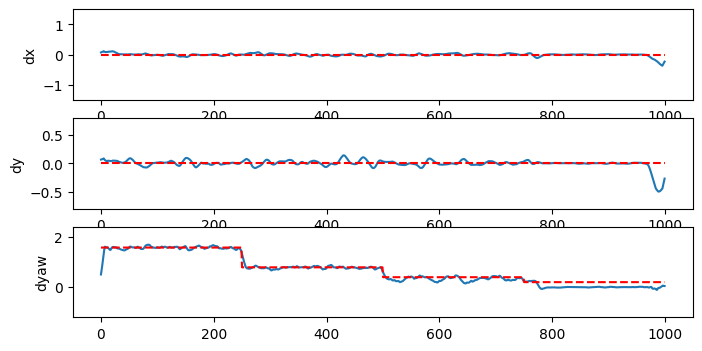

In [10]:
# visualization
# Plot each foot in a 2x2 grid.
if env_name == "Go1JoystickFlatTerrain":
    swing_peak = jax.numpy.array(swing_peak)
    names = ["FR", "FL", "RR", "RL"]
    colors = ["r", "g", "b", "y"]
    fig, axs = plt.subplots(2, 2)
    for i, ax in enumerate(axs.flat):
        ax.plot(swing_peak[:, i], color=colors[i])
        ax.set_ylim([0, env.env_cfg.reward_config.max_foot_height * 1.25])
        ax.axhline(env.env_cfg.reward_config.max_foot_height, color="k", linestyle="--")
        ax.set_title(names[i])
        ax.set_xlabel("time")
        ax.set_ylabel("height")
    plt.tight_layout()
    plt.show()

    linvel_x = jax.numpy.array(linvel)[:, 0]
    linvel_y = jax.numpy.array(linvel)[:, 1]
    angvel_yaw = jax.numpy.array(angvel)[:, 2]

    # Plot whether velocity is within the command range.
    linvel_x = jax.numpy.convolve(linvel_x, jax.numpy.ones(10) / 10, mode="same")
    linvel_y = jax.numpy.convolve(linvel_y, jax.numpy.ones(10) / 10, mode="same")
    angvel_yaw = jax.numpy.convolve(angvel_yaw, jax.numpy.ones(10) / 10, mode="same")

    fig, axes = plt.subplots(3, 1, figsize=(8, 4))
    axes[0].plot(linvel_x)
    axes[1].plot(linvel_y)
    axes[2].plot(angvel_yaw)

    axes[0].set_ylim(-env.env_cfg.command_config.a[0], env.env_cfg.command_config.a[0])
    axes[1].set_ylim(-env.env_cfg.command_config.a[1], env.env_cfg.command_config.a[1])
    axes[2].set_ylim(-env.env_cfg.command_config.a[2], env.env_cfg.command_config.a[2] * 2)

    ref_cmd = jax.numpy.vstack(ref_commands)
    for i, ax in enumerate(axes):
        ax.plot(ref_cmd[:, i], color="red", linestyle="--")

    labels = ["dx", "dy", "dyaw"]
    for i, ax in enumerate(axes):
        ax.set_ylabel(labels[i])
else:
    print("No signal plots for Go1Handstand")

In [11]:
render_every = 2
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(traj, camera="track", scene_option=scene_option, height=480, width=640)
mediapy.show_video(frames, fps=fps, loop=False)

100%|██████████| 500/500 [06:11<00:00,  1.35it/s]
